# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

# Data Loading

In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz" -O training_images_full.npz
!wget "https://sussex.box.com/shared/static/axweldiirenlc4a6xn06l6heiuawodpa.npz" -O training_images_subset.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/2ss21w2g8nd8fshhtu9r2ww2mm04xh9f.npz" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/65pyy3pjnkl5yda7ra4rvhcd89l6i7fq.npzz" -O examples.npz



--2023-05-01 15:48:40--  https://sussex.box.com/shared/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from sussex.box.com attempted to set domain to box.net
Location: /public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz [following]
--2023-05-01 15:48:40--  https://sussex.box.com/public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from sussex.box.com attempted to set domain to box.net
Location: https://sussex.app.box.com/public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz [following]
--2023-05-01 15:48:40--  https://sussex.app.box.com/public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Conn

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('/content/drive/MyDrive/CV/training_images_full.npz', '69927c788396d4b8c05d33d1650b2aa66076c0f0')
confirm_checksum('/content/drive/MyDrive/CV/training_images_subset.npz', '5e2690718c7b1a0d14db54f844e6e22453f5eb71')
confirm_checksum('/content/drive/MyDrive/CV/test_images.npz', 'aed32f84664e906624c8af13b5462cbded13d539')
confirm_checksum('/content/drive/MyDrive/CV/examples.npz', '2ea08d7b6d76b56de97325fe51daad72afaa3d73')

# Load the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np


# Load the data using np.load
data = np.load('/content/drive/MyDrive/CV/training_images_full.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

# Load the data that only has a subset of annotations using np.load
data = np.load('/content/drive/MyDrive/CV/training_images_subset.npz', allow_pickle=True)

# Extract the images
images_subset = data['images']
# and the data points
pts_subset = data['points']

print(images_subset.shape, pts_subset.shape)

test_data = np.load('/content/drive/MyDrive/CV/test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('/content/drive/MyDrive/CV/examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)
 

(1425, 256, 256, 3) (1425, 44, 2)
(1386, 256, 256, 3) (1386, 5, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

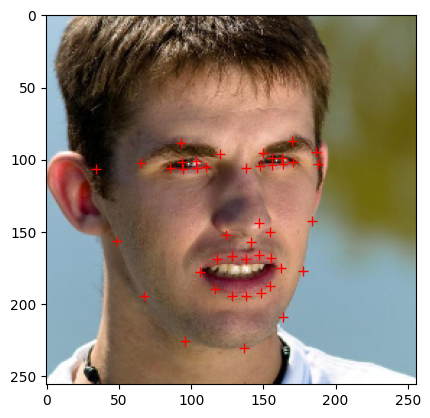

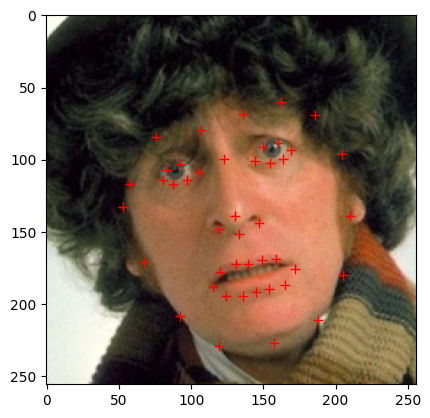

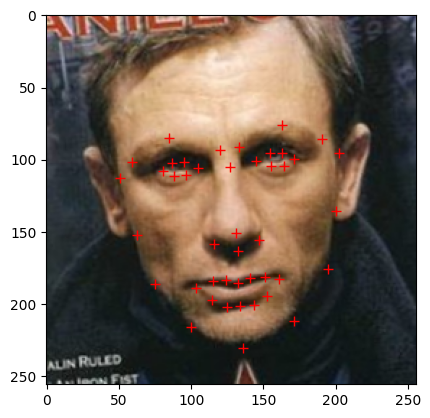

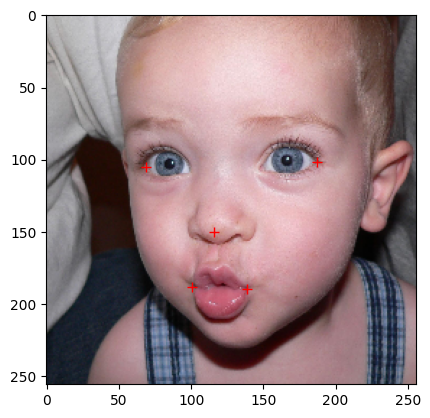

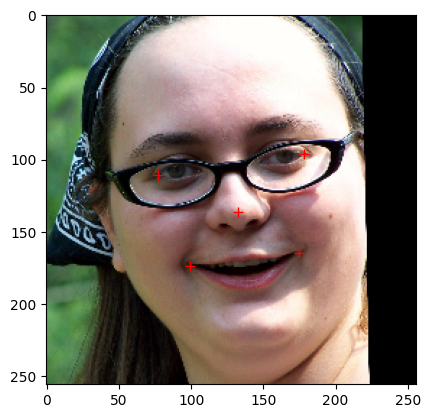

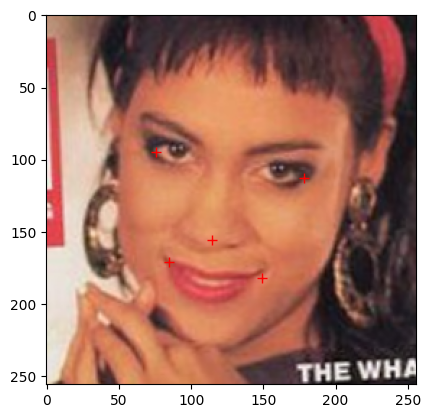

In [ ]:

def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r', ms=7)
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images_subset[idx, ...], pts_subset[idx, ...])

# Extracting Subset of Points from Full Set. Calculating Prediction Error. and Exporting Results

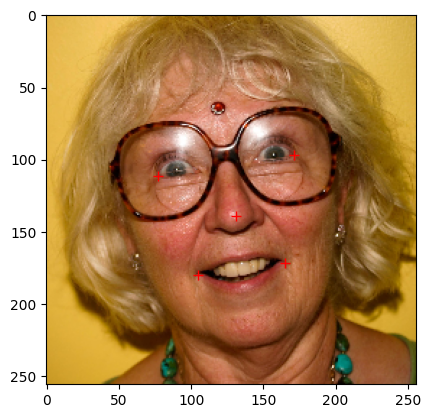

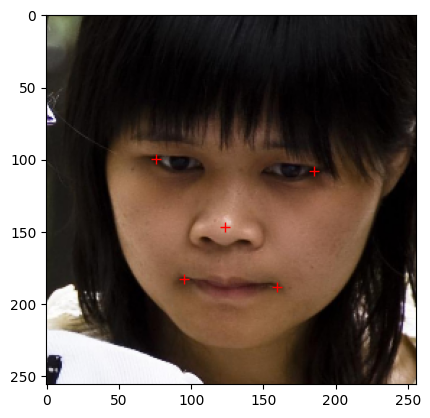

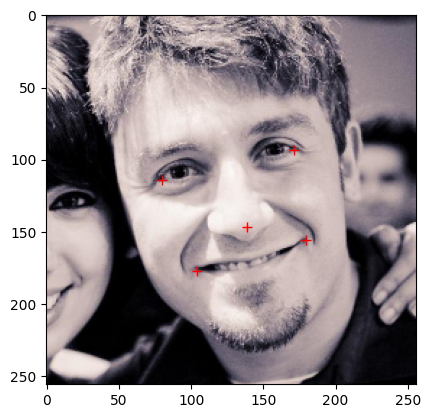

In [ ]:
def extract_subset_of_points(pts):
  indices = (20, 29, 16, 32, 38)
  if len(pts.shape) == 3:
    return pts[:, indices, :]
  elif len(pts.shape) == 2:
    return pts[indices, :]


for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], extract_subset_of_points(pts[idx, ...]))


In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Pre-process the images (e.g., normalization, resizing)
def preprocess_images(images):
  processed_images = []
  for img in images:
    # Normalize image to the range [0, 255] and convert to 8-bit unsigned integer
    img_normalized = (img / np.max(img) * 255).astype(np.uint8)
    processed_images.append(img_normalized)
  return np.array(processed_images)

processed_images_training = preprocess_images(images)
processed_images_testing = preprocess_images(test_images)



In [ ]:
# Define a custom grid or use evenly spaced points for feature extraction
grid_size = 8
grid_points = np.mgrid[0:256:grid_size, 0:256:grid_size].T.reshape(-1, 2)
feature_points = grid_points.astype(np.float32)

# Convert feature points to keypoints
keypoints = [cv2.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in feature_points]

# Extract SIFT features
sift = cv2.SIFT_create()
features = [sift.compute(image, keypoints)[1].flatten() for image in processed_images_training]
features_testing = [sift.compute(image, keypoints)[1].flatten() for image in processed_images_testing]

# Reshape the features array
features = np.array(features).reshape(len(features), -1)
features_testing = np.array(features_testing).reshape(len(features_testing), -1)

# Reshape the target variable
pts = pts.reshape(pts.shape[0], -1)

# Train a linear regression model
model = LinearRegression()
model.fit(features, pts)

# Evaluate the model
y_pred = model.predict(features_testing)

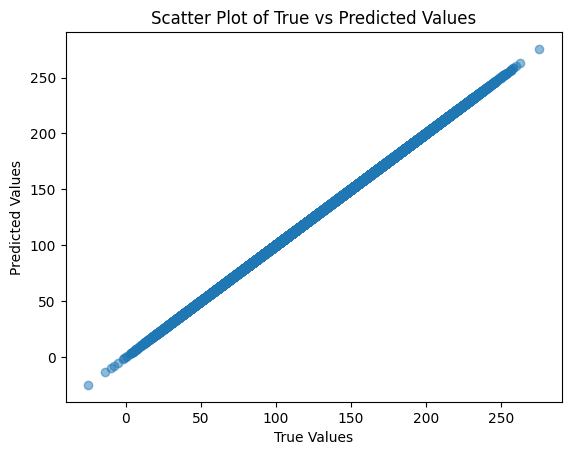

In [ ]:
import matplotlib.pyplot as plt
y_pred_training = model.predict(features)
plt.scatter(pts, y_pred_training, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of True vs Predicted Values")
plt.show()

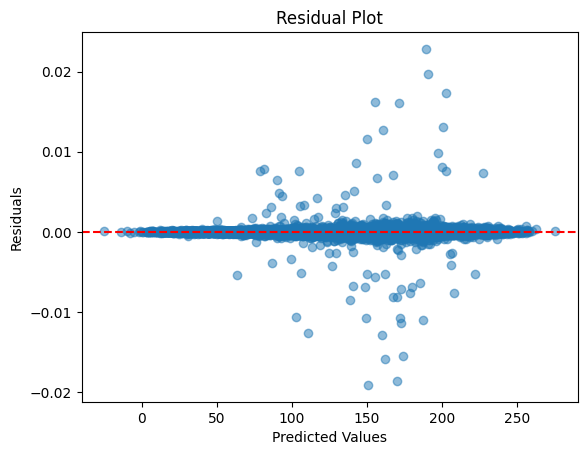

In [ ]:
y_true = pts
residuals = y_true - y_pred_training

plt.scatter(y_pred_training, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

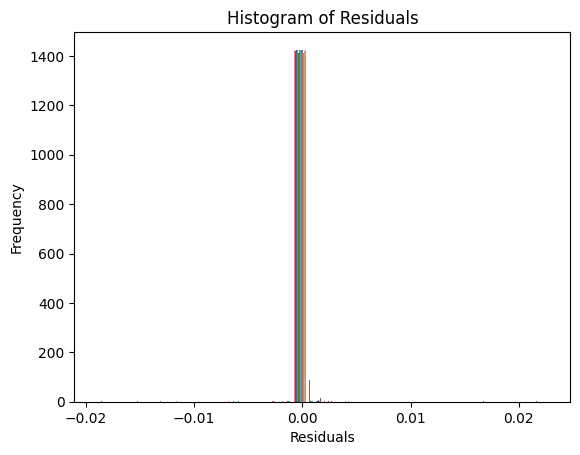

In [ ]:
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(pts, y_pred_training)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pts, y_pred_training)
r2 = r2_score(pts, y_pred_training)

print(f"MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR-squared: {r2:.4f}")


MSE: 0.0000
RMSE: 0.0002
MAE: 0.0001
R-squared: 1.0000


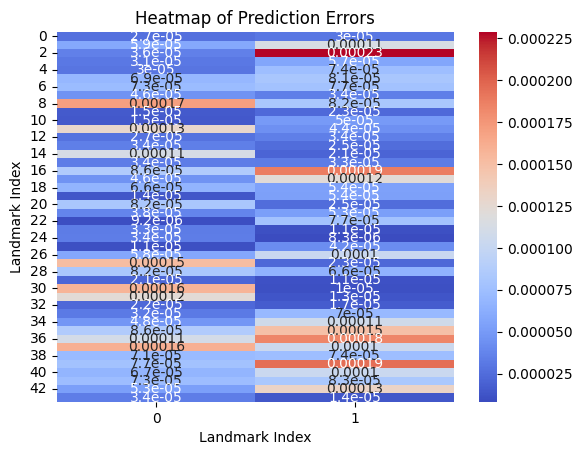

In [ ]:
import seaborn as sns

error_matrix = np.abs(pts - y_pred_training).reshape(-1, 44, 2)  # Adjust the shape based on your data
error_mean = error_matrix.mean(axis=0)

sns.heatmap(error_mean, cmap='coolwarm', annot=True)
plt.xlabel("Landmark Index")
plt.ylabel("Landmark Index")
plt.title("Heatmap of Prediction Errors")
plt.show()


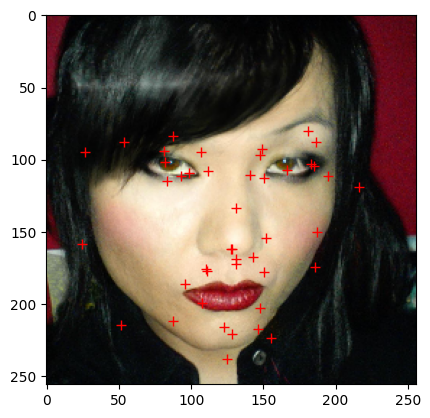

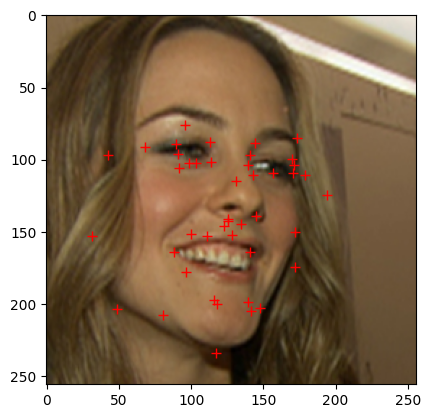

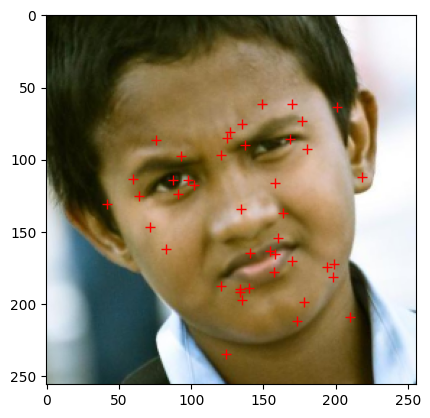

In [ ]:
# Reshape the predicted landmarks to the original shape
y_pred_reshaped = y_pred.reshape(-1, pts.shape[1]//2, 2)

# Visualize the predicted landmarks on input images
for i in range(3):
  idx = i
  visualise_pts(test_images[idx], y_pred_reshaped[idx])

Train the first model to predict the 5 known landmarks:

In [ ]:
# Prepare the training data for the first model
pts_subset = pts[:, (20, 29, 16, 32, 38)]
pts_subset_flat = pts_subset.reshape(pts_subset.shape[0], -1)

# Train the first model (Linear Regression)
model_1 = LinearRegression()
model_1.fit(features, pts_subset_flat)

# Predict the 5 known landmarks on the test set
y_pred_5 = model_1.predict(features_testing)
y_pred_5_reshaped = y_pred_5.reshape(-1, pts_subset.shape[1], 2)

Train the second model to predict the remaining 39 landmarks based on the 5 initial landmark predictions:

In [ ]:
# Concatenate the predicted 5 landmarks to the features
features_with_5_landmarks = np.concatenate((features, pts_subset_flat), axis=1)

# Prepare the target variable for the second model
pts_remaining = np.delete(pts, [20, 29, 16, 32, 38], axis=1)
pts_remaining_flat = pts_remaining.reshape(pts_remaining.shape[0], -1)

# Train the second model (Linear Regression)
model_2 = LinearRegression()
model_2.fit(features_with_5_landmarks, pts_remaining_flat)


LinearRegression()

Predict the remaining 39 landmarks on the test set:

In [ ]:
# Concatenate the predicted 5 landmarks to the test features
features_testing_with_5_landmarks = np.concatenate((features_testing, y_pred_5), axis=1)

# Predict the remaining 39 landmarks on the test set
y_pred_remaining = model_2.predict(features_testing_with_5_landmarks)
y_pred_remaining_reshaped = y_pred_remaining.reshape(-1, pts_remaining.shape[1], 2)


In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 34 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

save_as_csv(y_pred, '/content/drive/MyDrive/CV')